<a href="https://colab.research.google.com/github/grayhacked/AI/blob/main/Notebook1_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊 Analyse Exploratoire des Données multimodales

In [1]:
#importation des librairies
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from PIL import Image
from torchvision import transforms
import random
from wordcloud import WordCloud

In [5]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving train.csv to train.csv
User uploaded file "train.csv" with length 2041143 bytes


In [9]:
df = pd.read_csv('train.csv', on_bad_lines='warn')
df.head()

<ipython-input-9-2520c5a762d2>:1: ParserWarning: Skipping line 9086: expected 3 fields, saw 4
Skipping line 9510: expected 3 fields, saw 4
Skipping line 18114: expected 3 fields, saw 4
Skipping line 27169: expected 3 fields, saw 4

  df = pd.read_csv('train.csv', on_bad_lines='warn')


ImageID  Labels                                            Caption
0   0.jpg       1   Woman in swim suit holding parasol on sunny day.
1   1.jpg    1 19  A couple of men riding horses on top of a gree...
2   2.jpg       1  They are brave for riding in the jungle on tho...
3   3.jpg  8 3 13  a black and silver clock tower at an intersect...
4   4.jpg   8 3 7   A train coming to a stop on the tracks out side.

In [11]:
# afficher les infos du dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29996 entries, 0 to 29995
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ImageID  29996 non-null  object
 1   Labels   29996 non-null  object
 2   Caption  29996 non-null  object
dtypes: object(3)
memory usage: 703.2+ KB


In [12]:
# afficher la description du dataset
df.describe()

ImageID Labels                                            Caption
count       29996  29996                                              29996
unique      29996    777                                              29232
top     29999.jpg      1  A man flying through the air while riding a sk...
freq            1  14073                                                 33

In [14]:
#afficher la taille du dataset
print("Taille du dataset : ",df.shape)

Taille du dataset :  (29996, 3)


In [16]:
#affichage des types de données
print("Le types des colonnes")
df.dtypes

Le types des colonnes


ImageID    object
Labels     object
Caption    object
dtype: object

In [17]:
#verification des valeurs manquantes
df.isnull().sum()

ImageID    0
Labels     0
Caption    0
dtype: int64

#2. Analyse de la variable cible (Labels)

In [18]:

distribution_labels = df['Labels'].value_counts()
print(distribution_labels)

Labels
1              14073
17               975
1 15             876
1 3              740
16               673
               ...  
3 13 14            1
1 10 13 7          1
11 1 3 15          1
1 3 14 6           1
1 3 8 18 19        1
Name: count, Length: 777, dtype: int64


In [20]:
from collections import Counter
from itertools import chain

# Transformer le texte en liste d'entiers
df["Labels_list"] = df["Labels"].apply(lambda x: list(map(int, x.split())))


# Extraire tous les labels dans une liste commune
all_labels = list(chain.from_iterable(df["Labels_list"]))

# Extraire tous les labels dans une liste commune
all_labels = list(chain.from_iterable(df["Labels_list"]))

# Compter la fréquence de chaque label
label_counts = Counter(all_labels)

# Afficher la distribution individuelle
print("Distribution de chaque label :")
for label, freq in label_counts.most_common():
    print(f"Label {label} : {freq} occurrences")

Distribution de chaque label :
Label 1 : 22794 occurrences
Label 3 : 4364 occurrences
Label 8 : 2210 occurrences
Label 15 : 1934 occurrences
Label 18 : 1525 occurrences
Label 10 : 1470 occurrences
Label 17 : 1430 occurrences
Label 6 : 1395 occurrences
Label 4 : 1272 occurrences
Label 7 : 1221 occurrences
Label 2 : 1164 occurrences
Label 5 : 1132 occurrences
Label 16 : 1099 occurrences
Label 9 : 1042 occurrences
Label 19 : 1020 occurrences
Label 13 : 605 occurrences
Label 11 : 603 occurrences
Label 14 : 252 occurrences


In [34]:
print(df["Labels_list"].head())

0           [1]
1       [1, 19]
2           [1]
3    [8, 3, 13]
4     [8, 3, 7]
Name: Labels_list, dtype: object


In [22]:
print("Nombre total de labels uniques :", len(label_counts))

Nombre total de labels uniques : 18


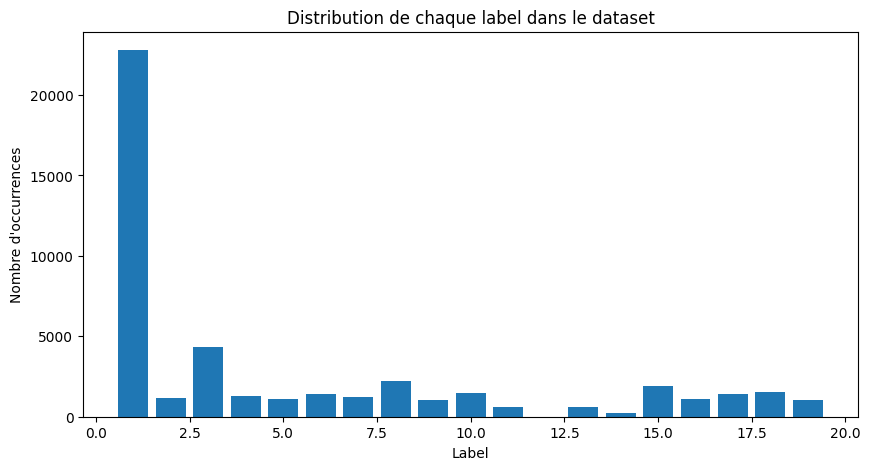

In [35]:
labels_unique = sorted(label_counts.keys())
frequencies = [label_counts[l] for l in labels_unique]

plt.figure(figsize=(10, 5))
plt.bar(labels_unique, frequencies)
plt.xlabel("Label")
plt.ylabel("Nombre d'occurrences")
plt.title("Distribution de chaque label dans le dataset")
plt.show()

# 2.3 Stratégie pour le déséquilibre
# On observe la distribution ; on discute ensuite (dans une cellule Markdown)
# => Weighted Loss, Data Augmentation, etc.

 ce graphique confirme que le dataset est largement dominé par la classe 1 et il y a vraiment une déséquilibre.

Vu que label 1 apparaît 22 000 fois et que label 14 n’a que 250 occurrences, on a un fort déséquilibre de classes. Pour y remédier, nous allons augmenter le poids des erreurs commises sur les classes minoritaires dans notre fonction de perte. De plus, nous pourrons appliquer une data augmentation ciblée sur les images rares pour augmenter la diversité. Ainsi, nous espérons que notre modèle ne sera pas trop biaisé vers la classe majoritaire.

Distribution du nombre de labels par image :
Labels_list
1    19374
2     6651
3     2562
4      978
5      339
6       81
7       11
Name: count, dtype: int64


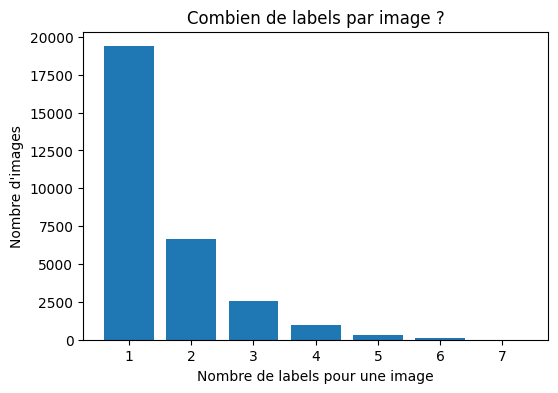

In [36]:
num_labels_per_image = df["Labels_list"].apply(len)
count_num_labels = num_labels_per_image.value_counts().sort_index()

print("Distribution du nombre de labels par image :")
print(count_num_labels)

# Petite visualisation
plt.figure(figsize=(6,4))
plt.bar(count_num_labels.index, count_num_labels.values)
plt.xlabel("Nombre de labels pour une image")
plt.ylabel("Nombre d'images")
plt.title("Combien de labels par image ?")
plt.show()


 ce graphique confirme que le dataset est largement dominé par des images à un seul label, avec un pourcentage plus faible (mais non négligeable) d’images à plusieurs labels.

#3. Exploration des images

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import zipfile
import os

# Chemin vers le fichier ZIP sur Google Drive
zip_file_path = '/content/drive/MyDrive/data.zip'

# Répertoire où décompresser les fichiers
extract_to_path = '/content/images'

# Créer le répertoire de destination s'il n'existe pas
os.makedirs(extract_to_path, exist_ok=True)

# Décompresser le fichier ZIP
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

# Vérifier les fichiers extraits
print(f"Fichiers extraits dans : {extract_to_path}")
!ls {extract_to_path}


Fichiers extraits dans : /content/images
data


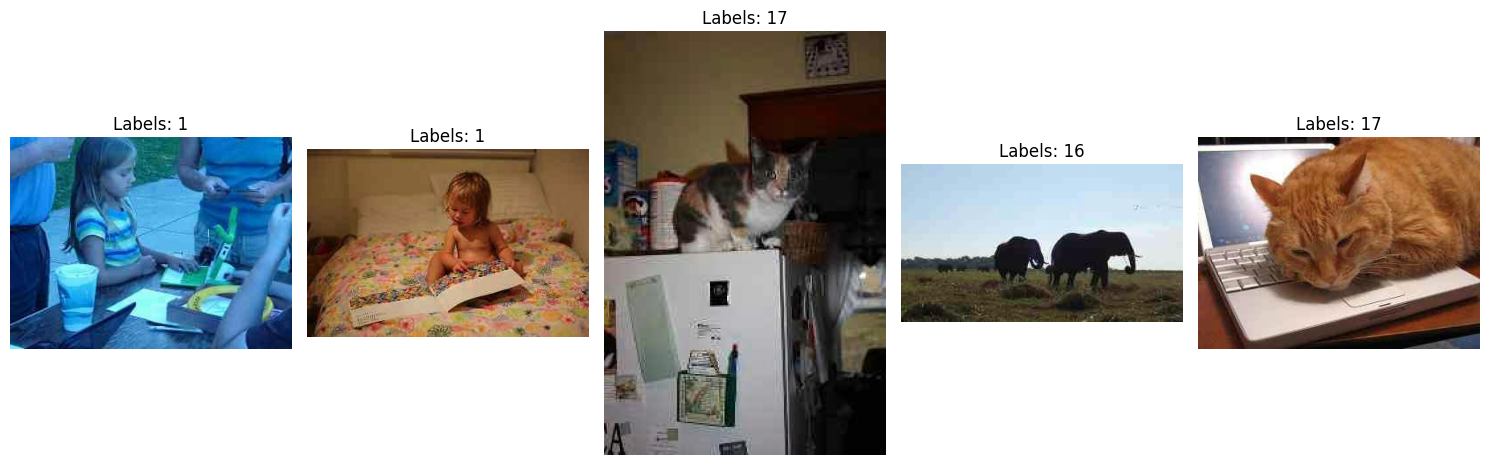

In [29]:
import random
import matplotlib.pyplot as plt
from PIL import Image

# Définir le dossier contenant les images
image_folder = "/content/images/data"  # adapter selon ton organisation

# Sélectionner aléatoirement 5 images du CSV
sample_df = df.sample(5, random_state=42)

plt.figure(figsize=(15, 5))

for i, (_, row) in enumerate(sample_df.iterrows()):
    img_path = os.path.join(image_folder, row["ImageID"])
    img = Image.open(img_path).convert("RGB")

    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"Labels: {row['Labels']}")  # Afficher les labels
    plt.axis("off")

plt.tight_layout()
plt.show()


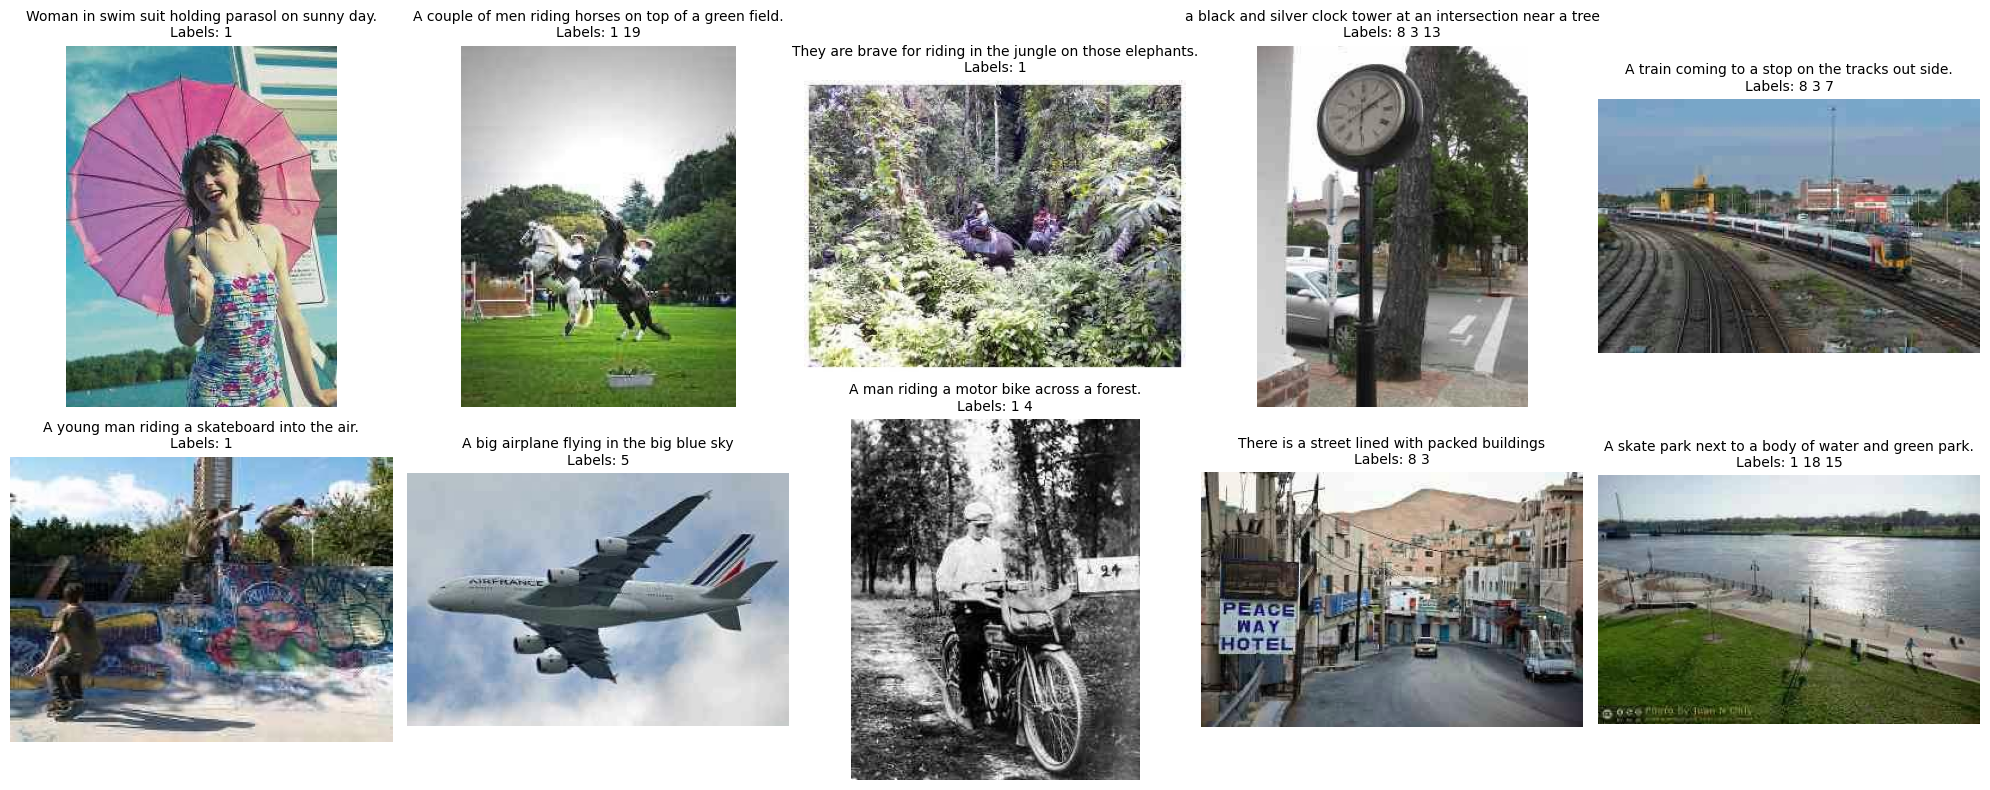

In [30]:
# Afficher les images chargées avec leurs captions et labels
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    image_name = f"{i}.jpg"
    image_path = os.path.join(image_folder, image_name)

    # Charger et afficher l'image
    img = Image.open(image_path)
    ax.imshow(img)
    ax.axis('off')

    # Obtenir caption et labels du dataframe CSV
    row = df[df['ImageID'] == image_name]
    if not row.empty:
        caption = row['Caption'].values[0]
        labels = row['Labels'].values[0]
        ax.set_title(f"{caption}\nLabels: {labels}", fontsize=10)
    else:
        ax.set_title("Pas de données CSV", fontsize=10)

plt.tight_layout()
plt.show()

#4. Analyse des descriptions textuelles

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


ImageID: 20958.jpg
Caption: A surfer on a beach holding his surfboard watching another surfer ride a wave.
Labels: 1
--------------------------------------------------
ImageID: 1150.jpg
Caption: A couple of cars parked next to the side of a road.
Labels: 3 4 6
--------------------------------------------------
ImageID: 22823.jpg
Caption: A young girl tossing a red and blue frisbee.
Labels: 1 3
--------------------------------------------------
ImageID: 22950.jpg
Caption: a red motorcycle on display on a white floor
Labels: 1 4
--------------------------------------------------
ImageID: 3078.jpg
Caption: A group of young men playing a game frisbee.
Labels: 1
--------------------------------------------------
Longueur moyenne des descriptions : 10.49 mots


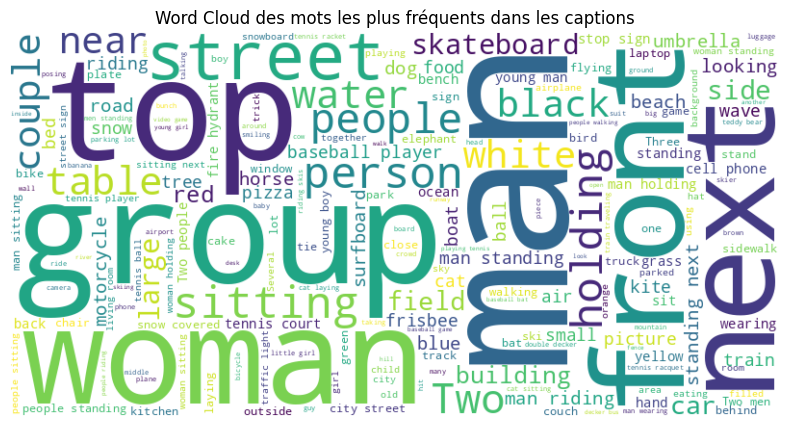

In [31]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# 4.1 Afficher quelques exemples de descriptions
for i in range(5):
    sample = df.sample(1).iloc[0]
    print("ImageID:", sample["ImageID"])
    print("Caption:", sample["Caption"])
    print("Labels:", sample["Labels"])
    print("-"*50)

# 4.2 Analyser la longueur moyenne des descriptions
df["Caption_length"] = df["Caption"].apply(lambda x: len(str(x).split()))
mean_length = df["Caption_length"].mean()
print(f"Longueur moyenne des descriptions : {mean_length:.2f} mots")

# 4.3 Identifier les mots les plus fréquents (Word Cloud)
all_captions = " ".join(df["Caption"].dropna())
# Filtrer les stopwords (optionnel)
stop_words = set(stopwords.words('english'))  # ou 'french' si c’est en français

wordcloud = WordCloud(width=800, height=400, background_color="white",
                      stopwords=stop_words).generate(all_captions)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud des mots les plus fréquents dans les captions")
plt.show()


#5. Exploration des relations entre images, textes et labels

Objectif : Identifier des patterns entre :

Les labels (ex: label 5 = “airplane”, label 1 = “person”, etc.).

Les images associées (quelles sont leurs caractéristiques visuelles ?).

Le texte / la caption (quels mots sont récurrents quand un label apparaît ?).

In [37]:
from collections import Counter
from itertools import chain

# On choisit un label pour l'étude, ex: label 5
label_to_explore = 5


# Filtrer le dataset pour ne garder que les images portant ce label
df_label = df[df["Labels_list"].apply(lambda labels: label_to_explore in labels)]
print(f"Nombre d'images avec le label {label_to_explore} :", len(df_label))

Nombre d'images avec le label 5 : 1132


In [38]:
# Afficher quelques images + captions
sample_label = df_label.sample(5, random_state=42)
for idx, row in sample_label.iterrows():
    print("ImageID:", row["ImageID"])
    print("Caption:", row["Caption"])
    print("Labels:", row["Labels_list"])
    print("-"*50)

ImageID: 21073.jpg
Caption: A large plane flying high in a blue cloudy sky
Labels: [5]
--------------------------------------------------
ImageID: 23961.jpg
Caption: a large plane on an air port run way
Labels: [8, 5]
--------------------------------------------------
ImageID: 12010.jpg
Caption: A big commercial plane parked near some small gates.
Labels: [5]
--------------------------------------------------
ImageID: 13264.jpg
Caption: a big propeller sits on a run way
Labels: [1, 5]
--------------------------------------------------
ImageID: 20224.jpg
Caption: An engine on a large airplane on a runway.
Labels: [1, 5]
--------------------------------------------------


Nombre d'images avec le label 5 : 1132


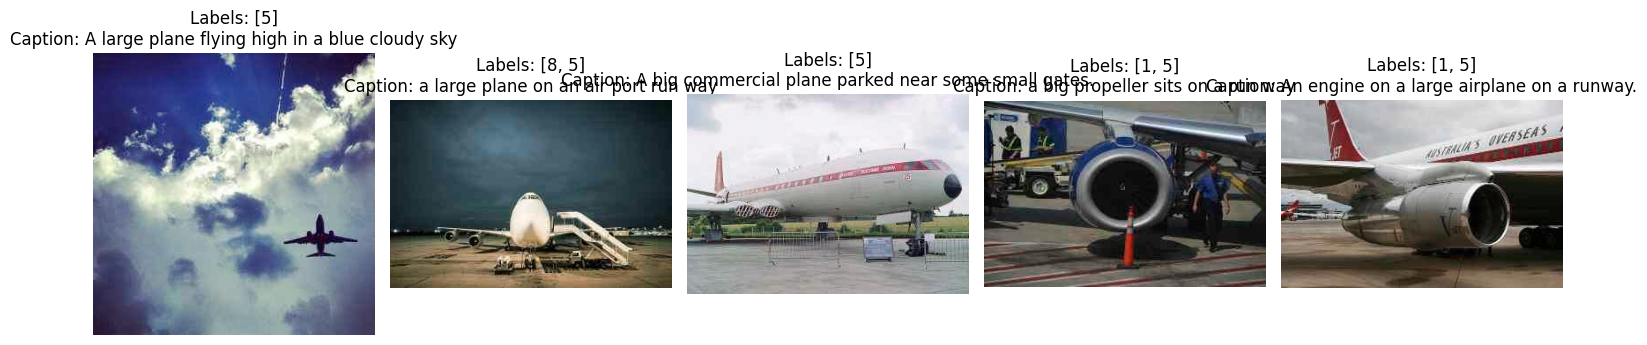

In [41]:

label_to_explore = 5

# 1. Filtrer le dataset pour ne garder que les images portant ce label
df_label = df[df["Labels_list"].apply(lambda labels: label_to_explore in labels)]
print(f"Nombre d'images avec le label {label_to_explore} :", len(df_label))

# 2. Sélectionner quelques images au hasard
sample_label = df_label.sample(5, random_state=42)

# 3. Afficher ces images
plt.figure(figsize=(15, 5))
for i, (_, row) in enumerate(sample_label.iterrows()):
    img_path = os.path.join(image_folder, row["ImageID"])
    img = Image.open(img_path).convert("RGB")

    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Labels: {row['Labels_list']}\nCaption: {row['Caption']}")
    plt.axis("off")

plt.tight_layout()
plt.show()


Dans cet affiche, on voit que quand le label 5 fait parti de la classe, il y a presence des avion

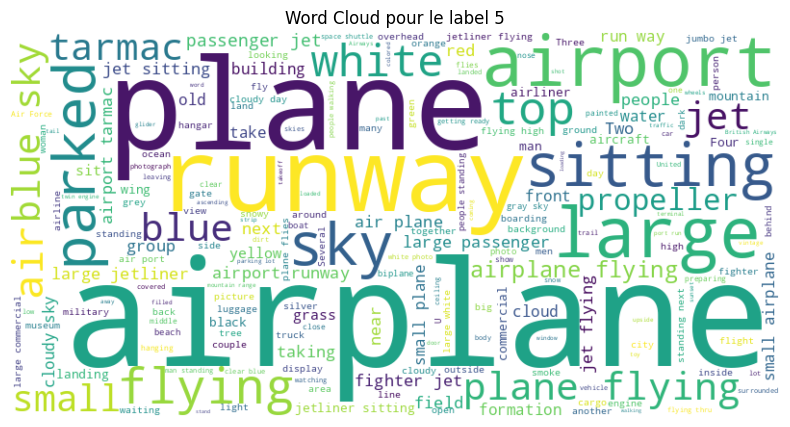

In [40]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text_label = " ".join(df_label["Caption"].dropna().astype(str))
wordcloud_label = WordCloud(width=800, height=400, background_color="white").generate(text_label)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_label, interpolation='bilinear')
plt.axis("off")
plt.title(f"Word Cloud pour le label {label_to_explore}")
plt.show()


But : voir si “plane”, “airplane”, “flight”, etc. apparaissent souvent.

#6. Séparation des données (70% train, 15% val, 15% test)

In [33]:
from sklearn.model_selection import train_test_split

# On part du CSV "train.csv" (annoté).
# On va split en interne (70,15,15).

train_df, temp_df = train_test_split(df, test_size=0.30, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.50, random_state=42)

print("Taille du set d'entraînement :", len(train_df))
print("Taille du set de validation :", len(val_df))
print("Taille du set de test :", len(test_df))

#  Sauvegarde en CSV si besoin
# train_df.to_csv("data/processed/train_split.csv", index=False)
# val_df.to_csv("data/processed/val_split.csv", index=False)
# test_df.to_csv("data/processed/test_split.csv", index=False)


Taille du set d'entraînement : 20997
Taille du set de validation : 4499
Taille du set de test : 4500
